<a href="https://colab.research.google.com/github/leehanchung/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/CAT_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"vitaminc","key":"0eb61e9a1314e9957682754bb623affc"}' > ~/.kaggle/kaggle.json

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [28]:
!pip install eli5 pdpbox category_encoders

In [29]:
!kaggle competitions download -c caterpillar-tube-pricing --force

  0% 0.00/225k [00:00<?, ?B/s]
100% 225k/225k [00:00<00:00, 69.4MB/s]
  0% 0.00/794k [00:00<?, ?B/s]
100% 794k/794k [00:00<00:00, 48.7MB/s]


In [30]:
!unzip caterpillar-tube-pricing.zip

unzip:  cannot find or open caterpillar-tube-pricing.zip, caterpillar-tube-pricing.zip.zip or caterpillar-tube-pricing.zip.ZIP.


!unzip data.zip

In [31]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv 

In [32]:
!pip install category_encoders

In [0]:
from glob import glob
import pandas as pd
import numpy as np

import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble, preprocessing
import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [34]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_other.csv (1001, 3)
competition_data/comp_adaptor.csv (25, 20)
competition_data/components.csv (2048, 3)
competition_data/type_end_form.csv (8, 2)
competition_data/tube.csv (21198, 16)
competition_data/comp_elbow.csv (178, 16)
competition_data/type_connection.csv (14, 2)
competition_data/train_set.csv (30213, 8)
competition_data/comp_tee.csv (4, 14)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_float.csv (16, 7)
competition_data/comp_boss.csv (147, 15)
competition_data/comp_hfl.csv (6, 9)
competition_data/comp_nut.csv (65, 11)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_sleeve.csv (50, 10)
competition_data/test_set.csv (30235, 8)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_threaded.csv (194, 32)
competition_data/specs.csv (21198, 11)
competition_data/type_component.csv (29, 2)


# 1. Loading Data

In [0]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')
tube = pd.read_csv('competition_data/tube.csv')
bom = pd.read_csv('competition_data/bill_of_materials.csv')
specs = pd.read_csv('competition_data/specs.csv')
submission = pd.read_csv('sample_submission.csv')

In [36]:
trainval.head(10)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [37]:
test.head(10)

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25
5,6,TA-00001,S-0066,2013-06-23,0,0,Yes,50
6,7,TA-00001,S-0066,2013-06-23,0,0,Yes,100
7,8,TA-00001,S-0066,2013-06-23,0,0,Yes,250
8,9,TA-00003,S-0066,2013-07-07,0,0,Yes,1
9,10,TA-00003,S-0066,2013-07-07,0,0,Yes,2


## 1.1 Adding tube.csv

Assuming diameter represenets the diameter of the tube, length represent the length of the tube, and wall represent the thickness of the tube, we can then calculate the size of the tube materials to be diameter * pi * length * wall.  We will create a separate `tube_size` column to hold that information then add it to the training set.

In [38]:
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [39]:
tube.tube_assembly_id.nunique(), tube.shape

(21198, (21198, 16))

In [0]:
tube['tube_size'] = tube.diameter * np.pi * tube.length * tube.wall

## 1.2. Do a naive summary of the quantity of total components used for each `tube_assembly_id`. We will save those information to  `num_components` to be added with the training set.

In [41]:
bom.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Sum the total components used while ignoring component_id as a heuristics
bom['num_components'] = bom[['quantity_1', 'quantity_2', 'quantity_3', 'quantity_4', "quantity_5", 'quantity_6', 'quantity_7', 'quantity_8']].sum(axis=1)

In [43]:
bom.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,num_components
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [44]:
bom.columns

Index(['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2',
       'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4',
       'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6',
       'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8',
       'quantity_8', 'num_components'],
      dtype='object')

## 1.3 Merging and preprocessing.

We are merging `tube_size` from `tube` dataframe and `num_components` from `bill_of_materials` dataframes into both training set and testing set.  We will also transform the `quote_date` column to datetime format.

In [0]:
trainval = pd.merge(trainval, tube[['tube_assembly_id', 'tube_size']], how='left', on='tube_assembly_id')
trainval = pd.merge(trainval, bom[['tube_assembly_id', 'num_components']], how='left', on='tube_assembly_id')
#trainval = pd.merge(trainval, tube, how='left', on='tube_assembly_id')
#trainval = pd.merge(trainval, bom, how='left', on='tube_assembly_id')
test = pd.merge(test, tube[['tube_assembly_id', 'tube_size']], how='left', on='tube_assembly_id')
test = pd.merge(test, bom[['tube_assembly_id', 'num_components']], how='left', on='tube_assembly_id')
#test = pd.merge(test, tube, how='left', on='tube_assembly_id')
#test = pd.merge(test, bom, how='left', on='tube_assembly_id')
test = test.drop(columns='id')

In [0]:
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
trainval['quote_date_year'] = trainval['quote_date'].dt.year
trainval['quote_date_month'] = trainval['quote_date'].dt.month
trainval = trainval.drop(columns='quote_date')
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True)
test['quote_date_year'] = test['quote_date'].dt.year
test['quote_date_month'] = test['quote_date'].dt.month
test = test.drop(columns='quote_date');

In [47]:
trainval.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,tube_size,num_components,quote_date_year,quote_date_month
0,TA-00002,S-0066,0,0,Yes,1,21.905933,1940.450256,2.0,2013,7
1,TA-00002,S-0066,0,0,Yes,2,12.341214,1940.450256,2.0,2013,7
2,TA-00002,S-0066,0,0,Yes,5,6.601826,1940.450256,2.0,2013,7
3,TA-00002,S-0066,0,0,Yes,10,4.687770,1940.450256,2.0,2013,7
4,TA-00002,S-0066,0,0,Yes,25,3.541561,1940.450256,2.0,2013,7


## 1.4 Training/Validation Split

Test dataset has completely different `tube_assembly_id` compare to the training set.  Thus, we are splitting the training set based on `tube_assembly_id`.

In [48]:
train_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()
len(train_tube_assemblies), len(test_tube_assemblies)

(8855, 8856)

In [49]:
set(train_tube_assemblies) & set(test_tube_assemblies)

set()

In [50]:
train_tube_assemblies, val_tube_assemblies = train_test_split(
    train_tube_assemblies, random_state=45
)
len(train_tube_assemblies), len(val_tube_assemblies)

(6641, 2214)

In [51]:
set(train_tube_assemblies) & set(val_tube_assemblies)

set()

In [0]:
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]
assert train.shape[0] + val.shape[0] == trainval.shape[0]

#2 . Training

In [0]:
# root mean square log error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [0]:
features = trainval.columns.to_list()

In [55]:
features

['tube_assembly_id',
 'supplier',
 'annual_usage',
 'min_order_quantity',
 'bracket_pricing',
 'quantity',
 'cost',
 'tube_size',
 'num_components',
 'quote_date_year',
 'quote_date_month']

In [56]:
features.remove('tube_assembly_id')
features.remove('cost')
print(features)
target = 'cost'

['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'tube_size', 'num_components', 'quote_date_year', 'quote_date_month']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

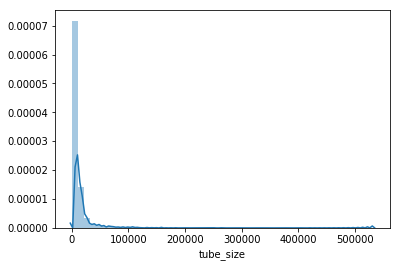

In [58]:
sns.distplot(X_train.tube_size)

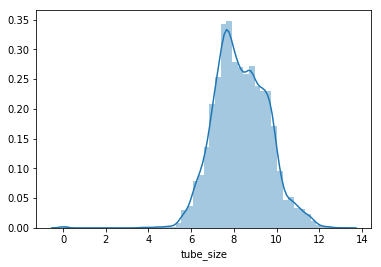

In [59]:
sns.distplot(np.log1p(X_train.tube_size))

In [0]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [61]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

%time pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

CPU times: user 9.22 s, sys: 164 ms, total: 9.39 s
Wall time: 4.91 s


0.3363101800815872

In [77]:
#encoder = ce.OrdinalEncoder()
#X_train_encoded = encoder.fit_transform(X_train)
#X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train, y_train_log), 
            (X_val, y_val_log)]

"""pipe = make_pipeline(
    ce.OrdinalEncoder(),
    xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, early_stopping_rounds=10, eval_metric='rmse', eval_set=eval_set)
)

"""

encoder = ce.OrdinalEncoder()
xgbr = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, early_stopping_rounds=10, eval_metric='rmse', eval_set=eval_set)

pipe = Pipeline(steps=[('encoder', encoder),
                       ('xgb', xgbr)]
)


#model = XGBRegressor(n_estimators=1000, n_jobs=-1)
%time pipe.fit(X_train, y_train_log)#, early_stopping_rounds=10, eval_metric='rmse', eval_set=eval_set)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 15.2 s, sys: 47.3 ms, total: 15.3 s
Wall time: 7.75 s


Pipeline(memory=None,
         steps=[('encoder',
                 OrdinalEncoder(cols=['supplier', 'bracket_pricing'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'supplier',
                                          'data_type': dtype('O'),
                                          'mapping': S-0066     1
S-0026     2
S-0013     3
S-0062     4
S-0014     5
S-0072     6
S-0064     7
S-0041     8
S-0087     9
S-0031    10
S-0054    11
S-0030    12
S-0015    13
S-0081    14
S-0018    15
S-0108    16
S-0058    17
S-0109...
30209    1.964544
30211    2.955647
Name: cost, Length: 7529, dtype: float64)],
                              gamma=0, importance_type='gain',
                              learning_rate=0.1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=1000

In [0]:
assert X_test.columns.tolist() == X_train.columns.tolist()

In [0]:
y_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['cost'] = y_pred
submission.to_csv('submission-02.csv', index=False)

In [65]:
#!kaggle competitions submit -c caterpillar-tube-pricing -f submission-02.csv -m "first"

100% 450k/450k [00:01<00:00, 234kB/s]
Successfully submitted to Caterpillar Tube Pricing

In [0]:
from xgboost import plot_importance

In [0]:
bst = pipe.named_steps['xgb']

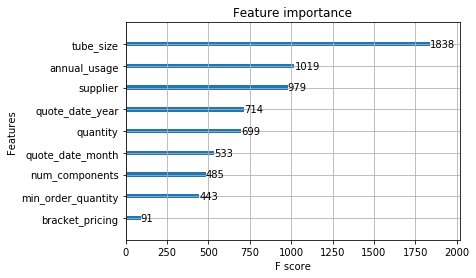

In [80]:
plot_importance(bst)

In [84]:
X_val.columns

Index(['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing',
       'quantity', 'tube_size', 'num_components', 'quote_date_year',
       'quote_date_month'],
      dtype='object')

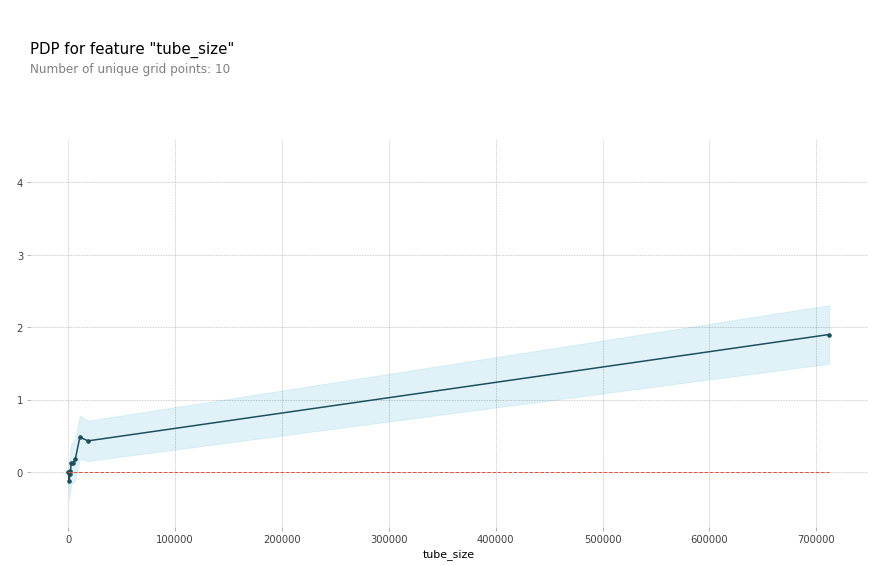

In [83]:
feature = 'tube_size'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

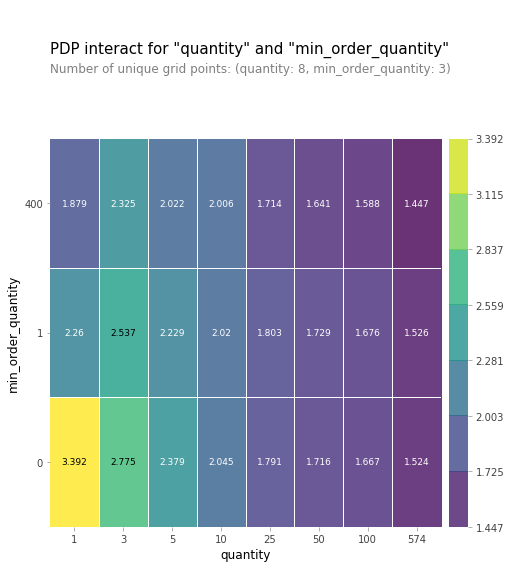

In [90]:
features = ['quantity', 'min_order_quantity']

interaction = pdp_interact(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

#pdp_plot(isolated, feature_name=feature);
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);